In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Load the .csv file
csv_file = 'C:\\Users\\Ashle\\OneDrive\\Desktop\\Lab codes\\2025 data\\carbenoxolone data\\carbenoxolone.csv'

#Read CSV file
data = pd.read_csv(csv_file) #reads the file
#print(data)

#all scoring has been reviewed, graphs reflet true data


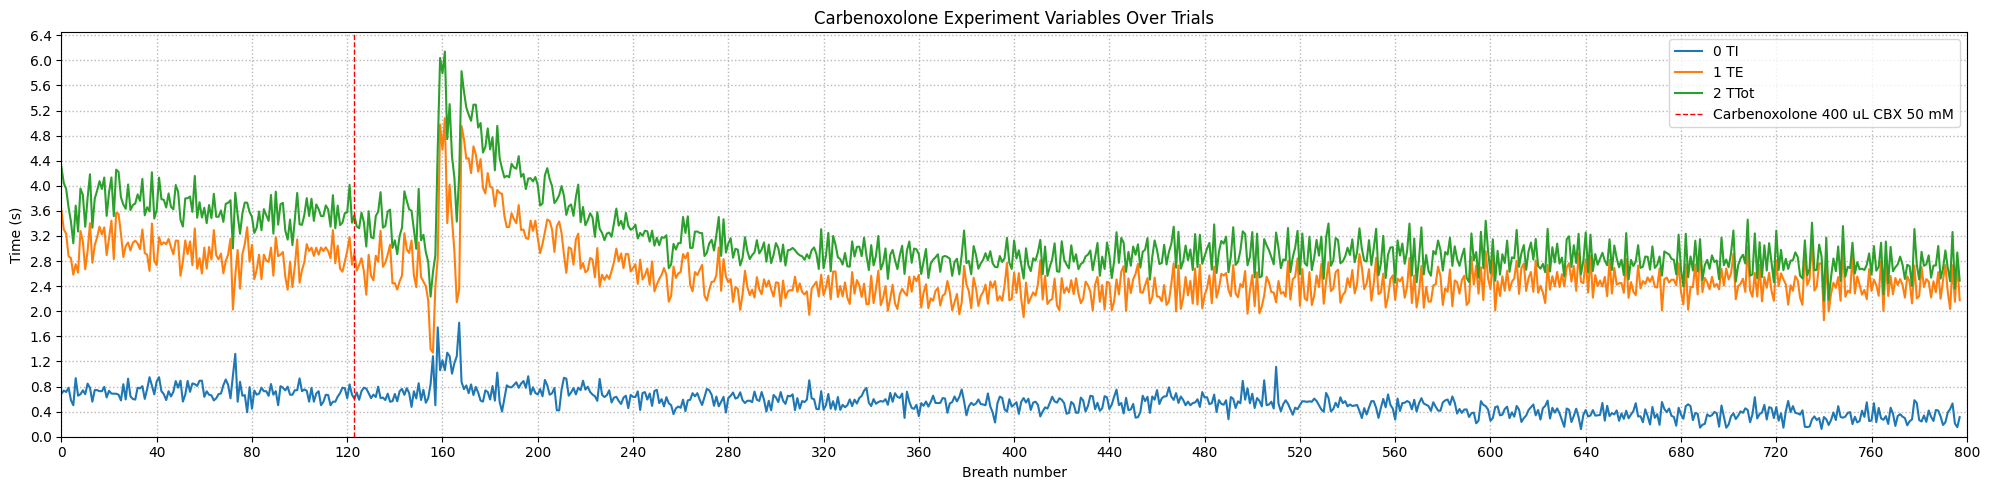

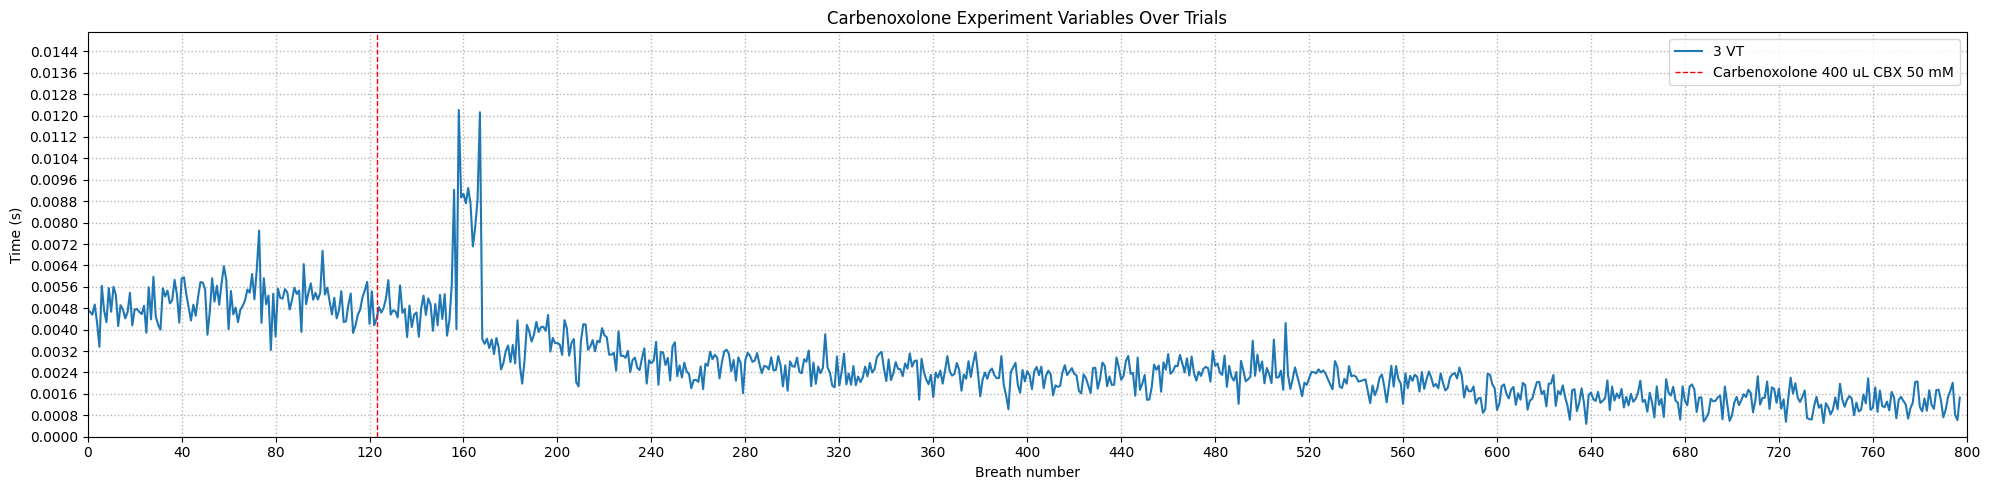

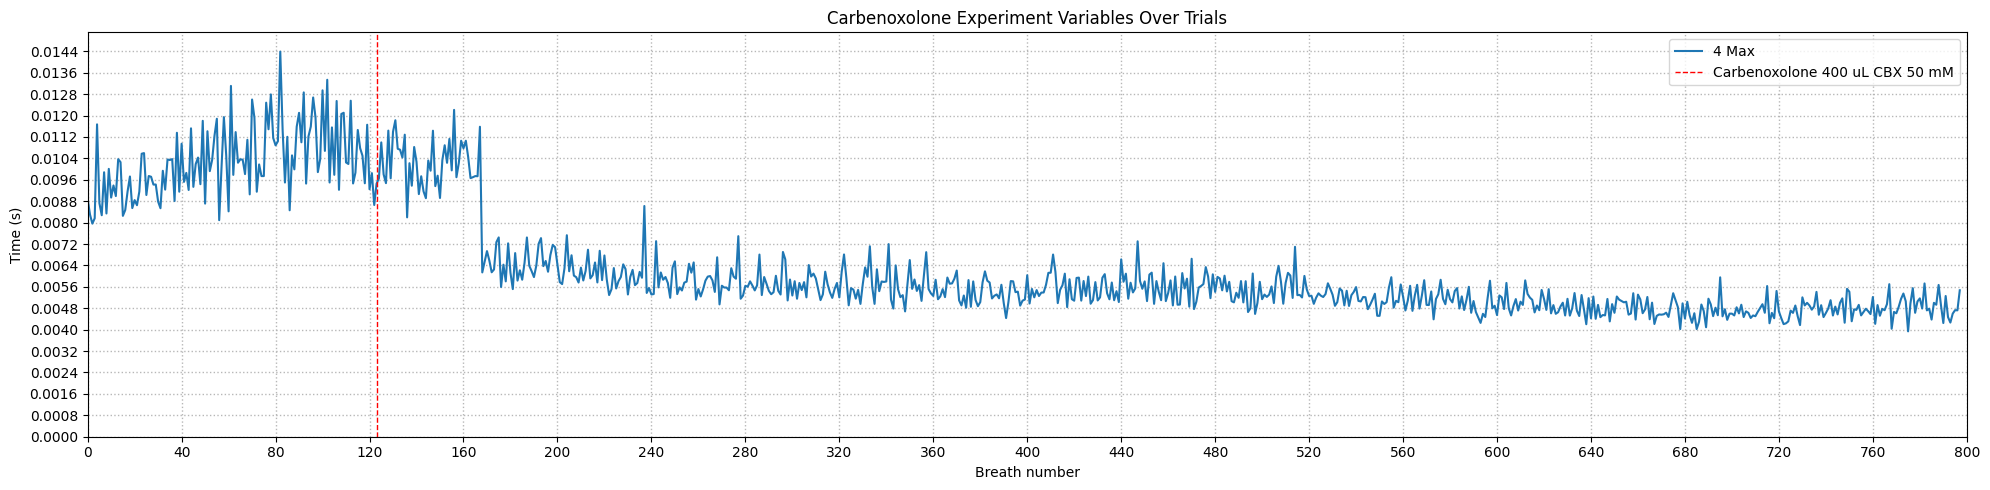

In [ ]:
group1 = ['0 TI', '1 TE', '2 TTot']
group2 = ['3 VT', '4 Max']

x = range(len(data)) #x axis range

plt.figure(figsize=(20, 5)) #figure size

for var in group1:
    plt.plot(x, data[var], label=var)

plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)  # style
plt.axvline(x=123, color='red', linestyle='--', linewidth=1, label='Carbenoxolone 400 uL CBX 50 mM')  #vertical line at breath 123 for the drug administration
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
plt.xlim([0,800]) # set x-axis limit    
plt.ylim(0, max(data[group1].max())*1.05)  # set y-axis limit
plt.xlabel('Breath number')
plt.ylabel('Time (s)')  # all variables are in seconds
plt.title('Carbenoxolone Experiment Variables Over Trials')
plt.legend() 
plt.tight_layout()
plt.show()



for var in group2:
    plt.figure(figsize=(20, 5)) #figure size
    plt.plot(x, data[var], label=var)
    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)  # style
    plt.axvline(x=123, color='red', linestyle='--', linewidth=1, label='Carbenoxolone 400 uL CBX 50 mM')  #vertical line at breath 123 for the drug administration
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.yaxis.set_major_locator(plt.MaxNLocator(20))
    plt.ylim(0, max(data[group2].max())*1.05)  # set y-axis limit
    plt.xlabel('Breath number')
    plt.ylabel('Time (s)')  # all variables are in seconds
    plt.title('Carbenoxolone Experiment Variables Over Trials')
    plt.legend() 
    plt.tight_layout()
    plt.show()

Normalized Mean % Change from Baseline:

0 TI: -28.48% change from baseline
1 TE: -13.97% change from baseline
2 TTot: -16.84% change from baseline
3 VT: -52.56% change from baseline
4 Max: -44.03% change from baseline


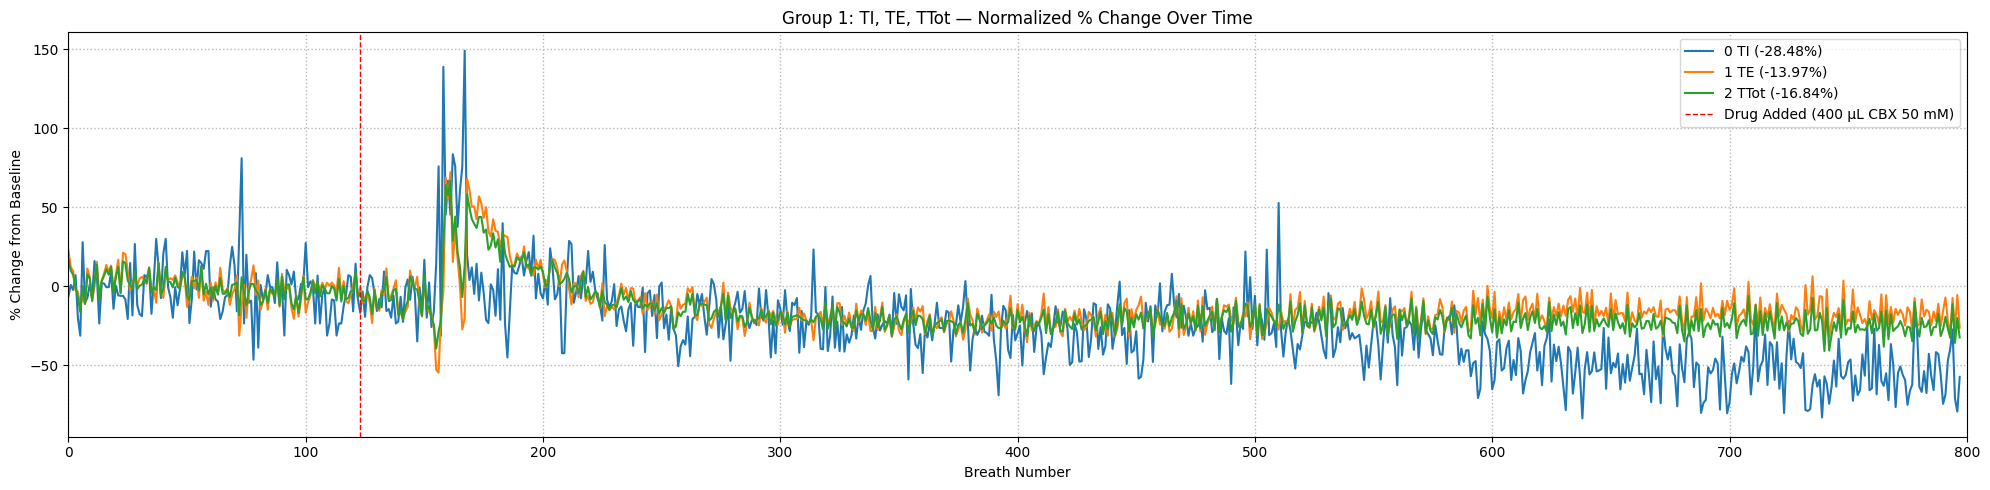

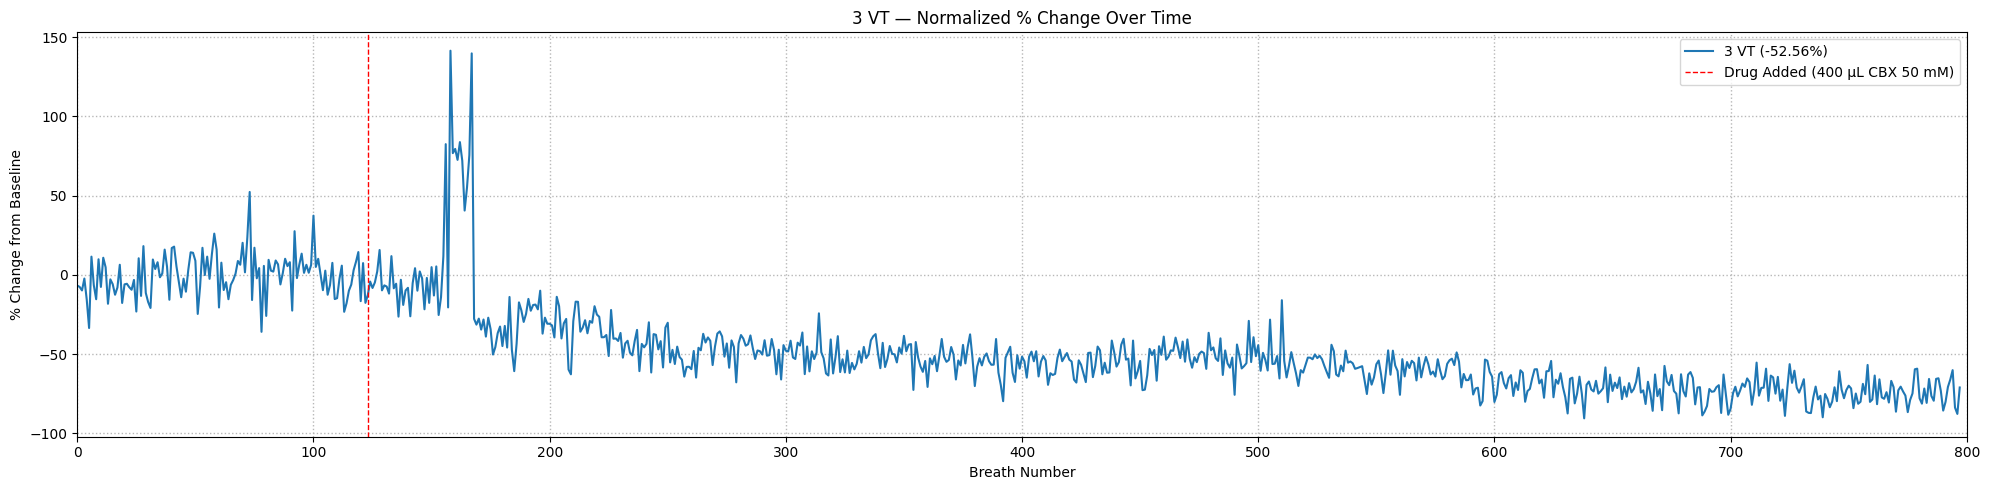

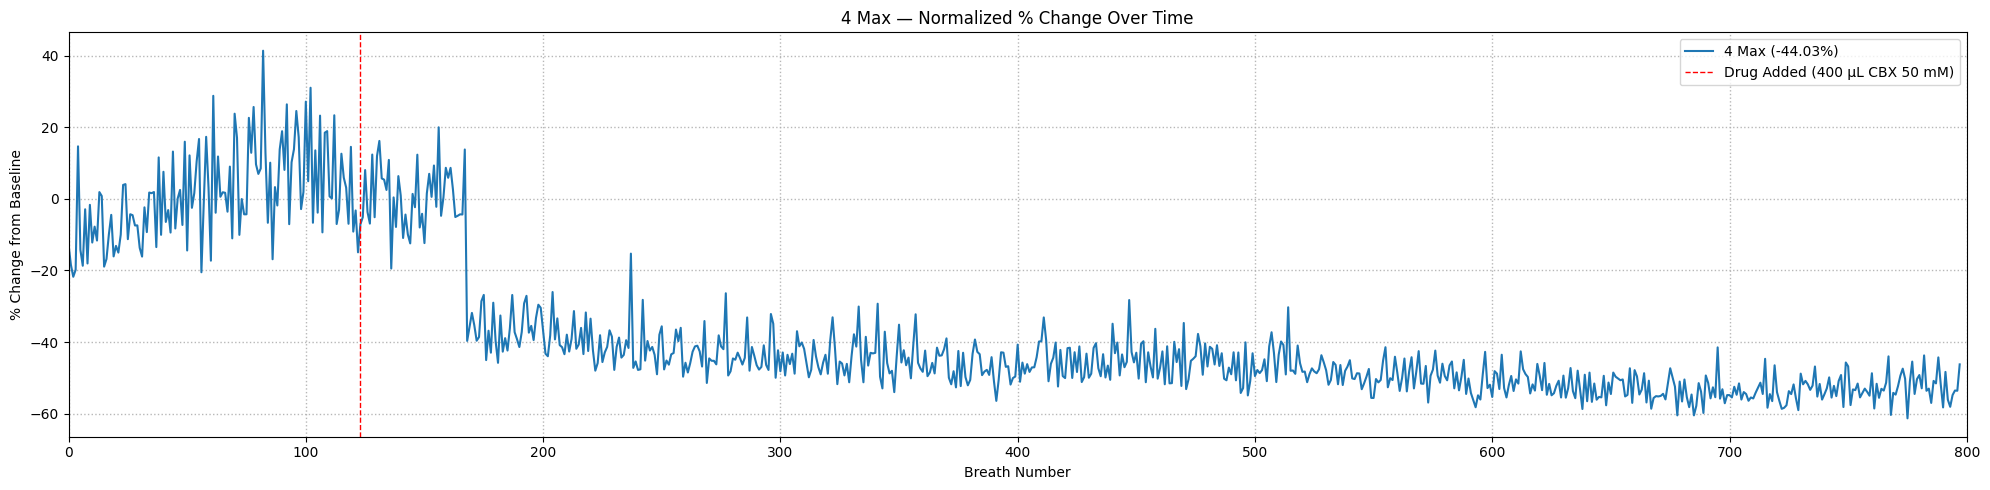

In [69]:
#Percent change from baseline (normalized) for all variables

baseline_range = (0, 100) # breaths 0-100 is baseline, didn't include breats close to drug administration
postdrug_range = (124, 800) # breaths 124-800 is post-drug


normalized_data = data.copy()
for var in group1 + group2:
    baseline_mean = data[var].iloc[baseline_range[0]:baseline_range[1]].mean()
    # Normalize so baseline = 0% (percent change)
    normalized_data[var] = ((data[var] - baseline_mean) / baseline_mean) * 100


percent_changes = {}
for var in group1 + group2:
    postdrug_mean = normalized_data[var].iloc[postdrug_range[0]:postdrug_range[1]].mean()
    percent_changes[var] = postdrug_mean

#print out the percent changes
print("Normalized Mean % Change from Baseline:\n")
for var, change in percent_changes.items():
    print(f"{var}: {change:.2f}% change from baseline")

#plot ti, te, ttot together
x = range(len(data))
plt.figure(figsize=(20, 5))
for var in group1:
    plt.plot(x, normalized_data[var], label=f"{var} ({percent_changes[var]:.2f}%)")

plt.axvline(x=123, color='red', linestyle='--', linewidth=1, label='Drug Added (400 µL CBX 50 mM)')
plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)
plt.xlim([0,800]) # set x-axis limit
plt.xlabel('Breath Number')
plt.ylabel('% Change from Baseline')
plt.title('Group 1: TI, TE, TTot — Normalized % Change Over Time')
plt.legend()
plt.tight_layout()
plt.show()

#plot vt and max separately
for var in group2:
    plt.figure(figsize=(20, 5))
    plt.plot(x, normalized_data[var], label=f"{var} ({percent_changes[var]:.2f}%)")
    plt.axvline(x=123, color='red', linestyle='--', linewidth=1, label='Drug Added (400 µL CBX 50 mM)')
    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)
    plt.xlim([0,800]) # set x-axis limit    
    plt.xlabel('Breath Number')
    plt.ylabel('% Change from Baseline')
    plt.title(f'{var} — Normalized % Change Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()



